In [1]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
from scipy import odr
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm, TABLEAU_COLORS
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids
import os

#imports
#FOR ASTROQUERRY: If you encounter an error related to "fields" in "SDSS.querry_crossid", try installing the newest development version of astroquerry rather than the default. There is a bug in the older official release version.

In [2]:
def lin_model(p, x): #We need this for ODR later.
    return p[0] * x + p[1]

class FrameData:

    def extract_data(self, file):
        hdul = fits.open(file)
        image = hdul[1].data
        header = hdul[1].header
        return image, header

    def add_realigned_image(self, aligned_image):
        self.aligned_image = aligned_image

    def add_reference_star(self, icrs_coords, pixel_coords, x_min, x_max, SDSS_filter_band):
        new_star = Star(icrs_coords, pixel_coords, x_min, x_max, SDSS_filter_band)
        self.star_list.append(new_star)

    def fill_out_star_list(self):
        for star in self.star_list:
            border_condition = (self.header['NAXIS1'] - star.pixel_coords[0]) < 0 or star.pixel_coords[0] < 0 or (self.header['NAXIS2'] - star.pixel_coords[1]) < 0 or star.pixel_coords[1] < 0
            if border_condition:
                star.flag = True

            regions_coordinate_object = PixCoord(star.pixel_coords[0], star.pixel_coords[1]) #No I dont know why you cant just pass a tuple. Screw you apparently.
            inner_annulus_radius = star.pixel_radius + 5
            outer_annulus_radius = star.pixel_radius + 10

            source_circle = CirclePixelRegion(regions_coordinate_object, star.pixel_radius).to_mask()
            source_aperture = source_circle.cutout(self.image)

            background_annulus = CircularAnnulus(star.pixel_coords, inner_annulus_radius, outer_annulus_radius)
            background_mean = ApertureStats(self.image, background_annulus).mean

            source_flux = np.sum(source_aperture - (source_circle * background_mean))

            sum_of_squared_noise = np.sum(source_circle * np.float64(self.read_noise**2))
            delta_n = (sum_of_squared_noise + source_flux
                       + (star.pixel_radius**2 / (outer_annulus_radius**2 - inner_annulus_radius**2))**2 
                       * (sum_of_squared_noise + aperture_photometry(self.image, background_annulus)['aperture_sum'][0]))**0.5
            
            star.instrumental_mag = -2.5 * np.log10(np.abs(source_flux))
            star.instrumental_mag_err = 2.5 * np.log10(np.e) * np.abs(delta_n / source_flux)
            if source_flux <= 0:
                star.flag = True
            
    def calibrate_frame(self, ref_thresh_mag=15):
        calibration_star_inst_mags = []
        calibration_star_inst_mag_errs = []
        calibration_star_SDSS_mags = []
        calibration_star_SDSS_mag_errs = []

        for star in self.star_list:
            #warning: the (x != None) check must go first so the and statement branches properly. Don't mess with this.
            reference_criteria = (star.SDSS_mag != None) and (star.SDSS_mag < ref_thresh_mag) and (star.flag == False)
            if reference_criteria:
                star.is_reference = True #might be useful information later to avoid cherrypicking.
                calibration_star_inst_mags.append(star.instrumental_mag)
                calibration_star_inst_mag_errs.append(star.instrumental_mag_err)
                calibration_star_SDSS_mags.append(star.SDSS_mag)
                calibration_star_SDSS_mag_errs.append(star.SDSS_mag_err)

        #Now the tricky bit. We have (uncorrelated, thank god) errors in both x and y so we must use Orthogonal Distance Regression. We'll use scipy's stupid package for this for consistency.
        linear = odr.Model(lin_model)
        zero_point_fit_data = odr.Data(calibration_star_inst_mags, calibration_star_SDSS_mags,
                                we=calibration_star_inst_mag_errs, wd=calibration_star_SDSS_mag_errs)
        odr_output = odr.ODR(zero_point_fit_data, linear, beta0=[1.0, 23.3]).run() #Beta0 is an initial guess based on known estimates.

        self.calibration_params = odr_output.beta
        self.calibration_param_errs = odr_output.sd_beta
        print(self.calibration_params)
        print(self.calibration_param_errs)

        for star in self.star_list:
            star.find_on_sky_magnitude(self.calibration_params, self.calibration_param_errs)
        
    def __init__(self, file):
        self.star_list = []
        self.image, self.header = self.extract_data(file)
        self.read_noise = self.header['rdnoise']
        self.calibration_params = None
        self.calibration_param_errs = None


class FrameSet:

    def align_frames(self):
        first_image = self.image_list[0]
        try:
            aligned = [aa.register(image, first_image)[0] for image in self.image_list[0:]]
        except:
            aligned = self.image_list
            raise UserWarning("AstroAlign did not align the frames")
        self.aligned = aligned

        for frame_index in range(len(self.frame_list)): #Store the aligned image in the FrameData object
            self.frame_list[frame_index].add_realigned_image(self.aligned[frame_index])

    # def create_template(self):
    #     self.template = np.median(self.aligned, axis=0)

    # def find_sources_from_template(self):
    #     background_object = sep.Background(self.template)
    #     self.sep_template_sources = sep.extract(self.template - background_object.back(), 3*background_object.globalrms, minarea=25, segmentation_map=False)

    def create_reference_stars(self, template_sources):
        for frame_index in range(len(self.frame_list)):
            for source in template_sources:
                pixel_coords = [source['x'], source['y']]
                icrs_coords = pixel_to_skycoord(pixel_coords[0], pixel_coords[1], self.WCS_matrix).transform_to('icrs')
                x_min = source['xmin']
                x_max = source['xmax']
                self.frame_list[frame_index].add_reference_star(icrs_coords=icrs_coords, pixel_coords=pixel_coords, x_min=x_min, x_max=x_max, SDSS_filter_band=self.filter_band)

    def __init__(self, directory):
        self.frame_list = []
        self.image_list = []
        self.header_list = []


        files = sorted(glob.glob(os.path.join(directory, r"*")))
        for file in files:
            frame = FrameData(file) #Create a new instance of FrameData for every file in the set directory
            self.frame_list.append(frame)
            self.image_list.append(frame.image)
            self.header_list.append(frame.header)

        self.WCS_matrix = None
        # self.WCS_matrix = WCS(self.header_list[0]) #The WCS matrix is (hypothetically) the same for every image so the first header is fine
        self.filter_band = self.header_list[0]['filter'][0] #This assumes the filter is the same for every image in the set. We can make this a variable option later but for now idgaf.
                                                            #Another brief note: the last 0th index is because LCO lists filters as 'xp' with the p representing prime. We just want the actual band letter, not the p.

class ObservationGroup: #A set of different frame sets. Usually different nights

    def populate_WCS_matrices(self):
        for run in self.run_list:
            run.WCS_matrix = WCS(self.run_list[0].header_list[0]) #Set the WCS matrix to be the same for every frame.

    def create_observation_template(self):
        self.template = np.median(self.run_list[0].aligned, axis=0)
    
    def find_sources_from_template(self):
        background_object = sep.Background(self.template)
        self.sep_template_sources = sep.extract(self.template - background_object.back(), 3*background_object.globalrms, minarea=25, segmentation_map=False)

    def populate_stars_in_frame_lists(self):
        for run in self.run_list:
            run.create_reference_stars(self.sep_template_sources)

    def characterize_stars_in_frame_lists(self):
        for run in self.run_list:
            for frame in run.frame_list:
                frame.fill_out_star_list()

    def calibrate_all_frames(self):
        for run in self.run_list:
            for frame in run.frame_list:
                frame.calibrate_frame()

    def __init__(self, file_path):
        self.run_list = []
        self.template = None
        self.sep_template_sources = None

        directories = sorted(glob.glob(file_path))
        for directory in directories:
            self.run_list.append(FrameSet(directory)) #Make a list of FrameSet objects.

        for run in self.run_list:
            run.align_frames()

        self.populate_WCS_matrices()
        self.create_observation_template()
        self.find_sources_from_template()
        self.populate_stars_in_frame_lists()
        self.characterize_stars_in_frame_lists()
        self.calibrate_all_frames()

class Star:

    def find_on_sky_magnitude(self, calibration_params, calibration_param_errs):
        self.on_sky_mag = calibration_params[0] * self.instrumental_mag + calibration_params[1]
        self.on_sky_mag_err = np.sqrt((calibration_params[0] * self.instrumental_mag)**2 
                                      * ((calibration_param_errs[0]/calibration_params[0])**2 + (self.instrumental_mag_err/self.instrumental_mag)**2) 
                                      + calibration_param_errs[1]**2)

    def __init__(self, icrs_coords, pixel_coords, x_min, x_max, SDSS_filter_band, source_id=None):
        self.icrs_coords = icrs_coords
        self.pixel_coords = pixel_coords
        self.x_min = x_min
        self.x_max = x_max
        self.SDSS_filter_band = SDSS_filter_band
        self.source_id = source_id
        self.instrumental_mag = None
        self.instrumental_mag_err = None
        self.flag = False #Flag flips to true if the source is potentially problematic such as a border source or a source with negative flux.
        self.SDSS_mag = None #By default assume there is not an SDSS magnitude associated with a star.
        self.SDSS_mag_err = None #And obviously then there is also no error in the SDSS magnitude...
        self.is_reference = False #By default stars aren't references. This gets toggled if they fit the criteria later.
        self.on_sky_mag = None
        self.on_sky_mag_err = None

        SDSS_reference_search = SDSS.query_crossid(self.icrs_coords, fields=['ra', 'dec', f'psfMag_{SDSS_filter_band}', f'psfMagErr_{SDSS_filter_band}'], radius=15*u.arcsec, region=False) #narrow field cone search to find source based on ra, dec.
        if SDSS_reference_search:
            if SDSS_reference_search['type'] == 'STAR':
                self.SDSS_mag = np.float64(SDSS_reference_search[f'psfMag_{SDSS_filter_band}'])
                self.SDSS_mag_err = np.float64(SDSS_reference_search[f'psfMagErr_{SDSS_filter_band}'])

        self.pixel_radius = (self.x_max - self.x_min) / 2

# class LightCurve:
    

In [3]:
test_file_path = r"C:\Users\Sam Whitebook\Documents\lubin_test_data\*"

obs_set1 = ObservationGroup(test_file_path)

Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[ 0.9319421 23.6064203]
[0.07602619 0.76682632]
[ 0.93390902 23.63314094]
[0.07634558 0.77063348]
[ 0.92618051 23.55222493]
[0.07806834 0.78773397]
[ 0.93551522 23.64173764]
[0.07786989 0.78537609]
[ 0.93118277 23.60272132]
[0.0747383  0.75413527]
[ 0.95243336 23.8074133 ]
[0.07847713 0.79120159]
[ 0.93599596 23.64472756]
[0.07438053 0.75002358]
[ 0.90960406 23.37568595]
[0.07422015 0.74805516]
[ 0.89047391 19.59133133]
[0.35827165 2.18947031]
[ 2.33585333 28.85150939]
[1.18081454 7.42495299]
[ 4.12258922 39.1230844 ]
[13.27696665 80.14065042]
[ 5.09077087 46.7508641 ]
[ 7.57418353 48.53751158]
[ 3.53557304 35.71292639]
[ 4.21733528 25.74580914]


In [ ]:
test_star = Star()

In [4]:
for run in obs_set1.run_list:
    for frame in run.frame_list:
        print(frame.star_list[0].icrs_coords)
        print(frame.star_list[0].pixel_coords)

<SkyCoord (ICRS): (ra, dec) in deg
    (210.7827489, 54.45969863)>
[92.22102481469487, 8.400264821849852]
<SkyCoord (ICRS): (ra, dec) in deg
    (210.7827489, 54.45969863)>
[92.22102481469487, 8.400264821849852]
<SkyCoord (ICRS): (ra, dec) in deg
    (210.7827489, 54.45969863)>
[92.22102481469487, 8.400264821849852]
<SkyCoord (ICRS): (ra, dec) in deg
    (210.7827489, 54.45969863)>
[92.22102481469487, 8.400264821849852]
<SkyCoord (ICRS): (ra, dec) in deg
    (210.7827489, 54.45969863)>
[92.22102481469487, 8.400264821849852]
<SkyCoord (ICRS): (ra, dec) in deg
    (210.7827489, 54.45969863)>
[92.22102481469487, 8.400264821849852]
<SkyCoord (ICRS): (ra, dec) in deg
    (210.7827489, 54.45969863)>
[92.22102481469487, 8.400264821849852]
<SkyCoord (ICRS): (ra, dec) in deg
    (210.7827489, 54.45969863)>
[92.22102481469487, 8.400264821849852]
<SkyCoord (ICRS): (ra, dec) in deg
    (210.7827489, 54.45969863)>
[92.22102481469487, 8.400264821849852]
<SkyCoord (ICRS): (ra, dec) in deg
    (210.78

In [5]:
for run in obs_set1.run_list:
    for frame in run.frame_list:
        print(frame.star_list[0].instrumental_mag)

-8.824332102218914
-8.854340911870391
-8.788847540005845
-8.871625456005638
-8.803174787861659
-8.843791630139764
-8.853990545856698
-8.646860906336528
-5.345371477306733
-6.655990072122559
-5.74105898454942
-6.386770464093897
-4.932220756839567


files = sorted(glob.glob(r"C:\Users\Sam Whitebook\Documents\lubin_test_data\*"))
print(files)
# files = sorted(glob.glob(r"C:\Users\Sam Whitebook\Documents\Visual Studio 2010\Projects\Lubin Lab\Data\sn2023ixf\sn2023ixf_r\sn2023ixf_2r\*"))

set1 = FrameSet(files)
set1.align_frames()
set1.create_template()
set1.store_aligned_frames()
set1.find_sources_from_template()
set1.create_reference_stars()
for frame in set1.frame_list:
    frame.fill_out_star_list()
    frame.calibrate_frame()

# plt.imshow(set1.template, norm=LogNorm(np.percentile(set1.template, 80), np.percentile(set1.template, 100)), cmap="gray", interpolation=None)

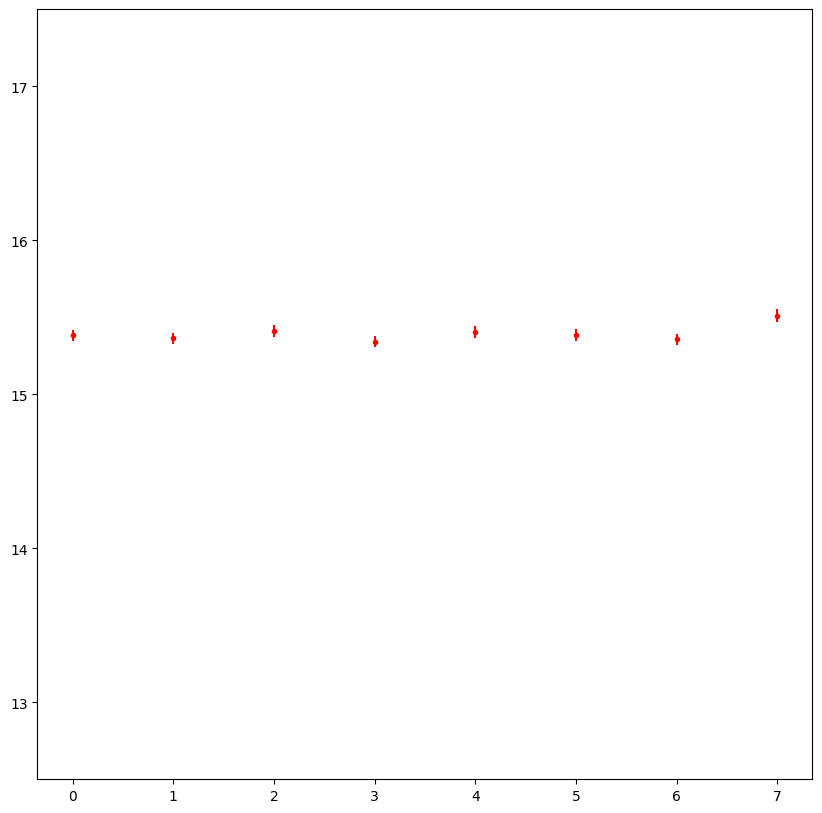

In [ ]:
star_mags = []
star_mag_errs = []
for frame in set1.frame_list:
    star_mags.append(frame.star_list[0].on_sky_mag)
    star_mag_errs.append(frame.star_list[0].instrumental_mag_err)
domain = np.arange(len(star_mags))

plt.figure(figsize=(10, 10))
# plt.plot(domain, m_list, color="red", linestyle="", marker=".")
plt.errorbar(domain, star_mags, yerr=star_mag_errs, color="red", linestyle="", marker=".")
plt.ylim(12.5, 17.5)
plt.show()

In [ ]:
test_star_mags = []
for i in range(len(set1.frame_list)):
    test_star_mags.append(set1.frame_list[i].star_list[0].instrumental_mag)